<a href="https://colab.research.google.com/github/dkaratzas/DL2022-23/blob/main/Problems%208%20-%20RNNs/P8_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/dkaratzas/DL2022-23/blob/main/Problems%208%20-%20RNNs/P8_RNNs.ipynb)

# Text generation with an RNN

In this notebook we will learn how to generate text with a Recurrent Neural Network.

We will work with a dataset of Shakespeare's writing from Andrej Karpathy's article [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). 

Given a sequence of characters from this data (for example "Shakespear"), we will train a model to predict the next character in the sequence ("e"). Longer sequences of text can be generated by calling the model repeatedly.

### Import the necessary modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from collections import Counter
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)

PyTorch Version:  2.0.0+cu118


In [2]:
#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Download the Shakespeare dataset

In [3]:
! wget https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt

--2023-05-02 09:26:27--  https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.128.128, 142.251.6.128, 74.125.124.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘shakespeare.txt’

shakespeare.txt     100%[===================>]   1.06M  --.-KB/s    in 0.01s   

2023-05-02 09:26:27 (87.3 MB/s) - ‘shakespeare.txt’ saved [1115394/1115394]



###  Create a dataset class

For training we need a dataset of (input, label) pairs. Where input and label are sequences of characters. At each time step the input is the current character and the label is the next character. For example:

```
input = ['S', 'h', 'a', 'k', 'e', 's', 'p', 'e', 'a', 'r']
label = ['h', 'a', 'k', 'e', 's', 'p', 'e', 'a', 'r', 'e']
 ```

Actually we will vectorize the characters to convert them into numerical values. 

```
input = [44, 7, 0, 10, 4, 18, 15, 4, 0, 17]
label = [7, 0, 10, 4, 18, 15, 4, 0, 17, 4]
```

where each integer value is a class label, and the number of classes is the number of unique characters in our training data (our vocabulary size).

In [4]:
class DatasetFromTextFile():
    def __init__(self, filename, sequence_length):
        self.filename = filename
        self.sequence_length = sequence_length
        
        # The whole sequence of characters in the text file (including characters like the end of line character '\n', punctuation marks, etc.)
        self.chars = self.load_chars()
        # The list of unique characters (our vocabulary)
        self.uniq_chars = self.get_uniq_chars()

        # A dictionary with indices as keys and characters as values
        self.index_to_char = {index: char for index, char in enumerate(self.uniq_chars)}
        # A dictionary with characters as keys and indices as values
        self.char_to_index = {char: index for index, char in enumerate(self.uniq_chars)}

        # The whole sequence of character indexes
        # We want to vectorize our text using one-hot vectors at character level
        # But instead of using the one-hot vector we just keep the index of the 1 value
        self.chars_indices = [self.char_to_index[w] for w in self.chars]

        # Split the sequence into chunks of `sequence_length` characters
        # `x` is the input to the model and `y` is the output of the model
        # `y` is the same seuqence as `x` but one character shifted to the right.
        self.x, self.y = self.get_data()

    def load_chars(self):
        with open(self.filename) as fp:
            text = fp.read()
        print(f'Length of text: {len(text)} characters')
        return text

    def get_uniq_chars(self):
        char_counts = Counter(self.chars)
        uniq_chars = sorted(char_counts, key=char_counts.get, reverse=True)
        print(f'Unique characters (vocabulary size): {len(uniq_chars)}')
        return uniq_chars

    def get_data(self):
        x,y = [], []
        for index in range(0, len(self.chars_indices)-self.sequence_length, self.sequence_length):
            x.append(np.array(self.chars_indices[index:index+self.sequence_length]))
            y.append(np.array(self.chars_indices[index+1:index+self.sequence_length+1]))
        
        return  torch.from_numpy(np.array(x)), torch.from_numpy(np.array(y)).long()
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        assert ((idx >= 0) & (idx < len(self.y))), "Dataset index out of range"
        return self.x[idx], self.y[idx]

Now we can use the [`torch.utils.data.TensorDataset`](https://pytorch.org/docs/stable/data.html) and [`torch.utils.data.Dataloader`](https://pytorch.org/docs/stable/data.html) classes to create the PyTorch dataloader. Notice that the `TensorDataset` class allows us to easily create a PyTorch `Dataset` from numpy arrays `(inputs, labels)`.

In [5]:
# Create the dataset
sequence_length = 100
ShakespeareDataset = DatasetFromTextFile('shakespeare.txt', sequence_length)

print(f'We have {ShakespeareDataset.x.shape[0]} input sequence samples of length {ShakespeareDataset.x.shape[1]} \
and {ShakespeareDataset.y.shape[0]} label sequences of length {ShakespeareDataset.y.shape[1]}')

# Create the Torch DataLoader
batch_size = 64
train_loader = DataLoader(ShakespeareDataset, shuffle=True, batch_size=batch_size, drop_last=True)

Length of text: 1115394 characters
Unique characters (vocabulary size): 65
We have 11153 input sequence samples of length 100 and 11153 label sequences of length 100


## Build the model

Our model has three layers:

* `torch.nn.Embedding`: The input layer. A trainable lookup table that will map each character-ID (class ID) to a dense vector with `embedding_dim` dimensions;
* `torch.nn.GRU`: A type of RNN with `hidden_dim` units
* `torch.nn.Linear`: The output layer, with number of outputs as our vocabulary size (`len(dataset.uniq_chars)`). It outputs one logit for each character in the vocabulary. These are the log-likelihood of each character according to the model.


For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

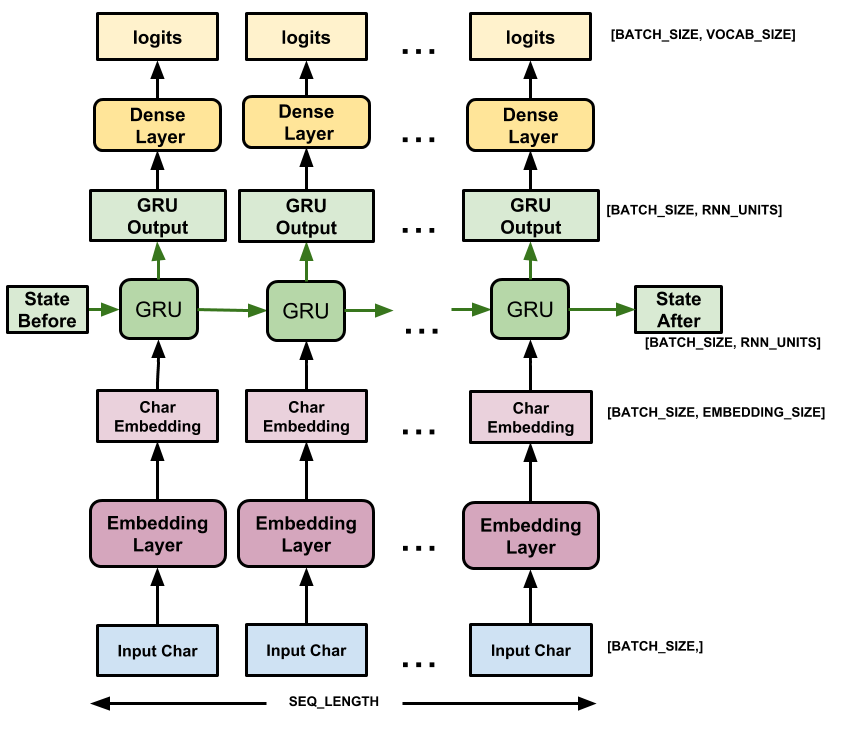

Image source: http://www.tensorflow.org

Additional info: http://mohitmayank.com/a_lazy_data_science_guide/natural_language_processing/lstm_gru_rnn/

Additional info: https://www.themachinelearners.com/modelos-secuencia/

<span style="color:blue">
    
**Exercise 1:** Complete the code of the `Model` class. You need to embed your input using an `nn.Embedding` layer, create a GRU with `n_layers`, and then compute the output logits.
    
</span>

In [6]:
class Model(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0.):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # YOUR CODE HERE
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, batch_first=True) 
        self.fc = nn.Linear(hidden_dim, output_dim)#... 
        
        
    def forward(self, x, h):
        emb = self.embedding(x)
        out, h = self.gru(emb, h)
        out = self.fc(out)
        return out, h
    
    def init_hidden(self, batch_size):
        " Initialize the hidden state of the RNN to zeros"
        hidden = nn.Parameter(torch.zeros(self.n_layers, batch_size, self.hidden_dim))
        return hidden

Now we can instantiate the model as follows:

In [7]:
input_dim = len(ShakespeareDataset.uniq_chars)
embedding_dim = 300
hidden_dim = 1024
output_dim = len(ShakespeareDataset.uniq_chars)
n_layers = 2
drop_prob = 0.2 

model = Model(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob).to(device)

print(model)

Model(
  (embedding): Embedding(65, 300)
  (gru): GRU(300, 1024, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1024, out_features=65, bias=True)
)


## Quick Experiment

Let's create a string and pass it through our model

In [8]:
data = torch.tensor([ShakespeareDataset.char_to_index[w] for w in "Hello"])
print(data.shape)

torch.Size([5])


Our model expects a batch. We will create a batch of 1, using this one data point we have created

In [9]:
data = data.unsqueeze(0) # this adds one more dimension (the batch one) to our data
print(data.shape)

torch.Size([1, 5])


Time to pass this through our model. To do so, we need to (1) move our data to the same device like the model and (2) initialise the state of our RNN

In [10]:
data = data.to(device)
state = model.init_hidden(batch_size = 1) # remember that we will use just a single data point jere
state = state.to(device)
out, state = model(data, state) # The forward pass expects the current state as an argument, and returns the updated state in the output

print(out.shape)

torch.Size([1, 5, 65])


Our output returns 65 probability values for each character... We need to find which one is the maximum probability for each position, and convert it to the corresponding character

In [11]:
_, idxs = torch.max(out[0], dim = 1)

print([ShakespeareDataset.index_to_char[int(c)] for c in idxs])

['M', 'M', 'M', 'Y', 'R']


As expected both inputs and outputs have the same shape, and the predicted characters are just random since the model is not trained yet.

## Train the model

Training a language model is essentially a classification problem. Given the previous RNN state, and the input character at this time step, predict the class of the next character.

<span style="color:blue">

**Exercise 2:** which loss function do you think we shall use to train our model?
    
</span>

In [12]:
def train(dataloader, model, batch_size, sequence_length, num_epochs):
    model.train()

    criterion =  nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []
    for epoch in range(num_epochs):

        for batch, (x, y) in enumerate(dataloader):
            state = model.init_hidden(batch_size) # Start with a new state in each batch            
            state = state.to(device)
            
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            
            y_pred, state = model(x, state)
            loss = criterion(y_pred.transpose(1, 2), y)

            loss.backward()
            optimizer.step()

            if batch%30 == 0:
                print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })
                losses.append(loss.item())
    return losses

Now train the model for 20 epochs and visualize the training loss curve.

In [13]:
num_epochs = 20

losses = train(train_loader, model, batch_size, sequence_length, num_epochs)

{'epoch': 0, 'batch': 0, 'loss': 4.171095848083496}
{'epoch': 0, 'batch': 30, 'loss': 2.2635414600372314}
{'epoch': 0, 'batch': 60, 'loss': 1.9723196029663086}
{'epoch': 0, 'batch': 90, 'loss': 1.780942440032959}
{'epoch': 0, 'batch': 120, 'loss': 1.6981064081192017}
{'epoch': 0, 'batch': 150, 'loss': 1.6389213800430298}
{'epoch': 1, 'batch': 0, 'loss': 1.5352779626846313}
{'epoch': 1, 'batch': 30, 'loss': 1.5605632066726685}
{'epoch': 1, 'batch': 60, 'loss': 1.4695031642913818}
{'epoch': 1, 'batch': 90, 'loss': 1.4604204893112183}
{'epoch': 1, 'batch': 120, 'loss': 1.4785536527633667}
{'epoch': 1, 'batch': 150, 'loss': 1.4651597738265991}
{'epoch': 2, 'batch': 0, 'loss': 1.3717249631881714}
{'epoch': 2, 'batch': 30, 'loss': 1.3668705224990845}
{'epoch': 2, 'batch': 60, 'loss': 1.3650522232055664}
{'epoch': 2, 'batch': 90, 'loss': 1.3671742677688599}
{'epoch': 2, 'batch': 120, 'loss': 1.3491668701171875}
{'epoch': 2, 'batch': 150, 'loss': 1.3216562271118164}
{'epoch': 3, 'batch': 0, 'l

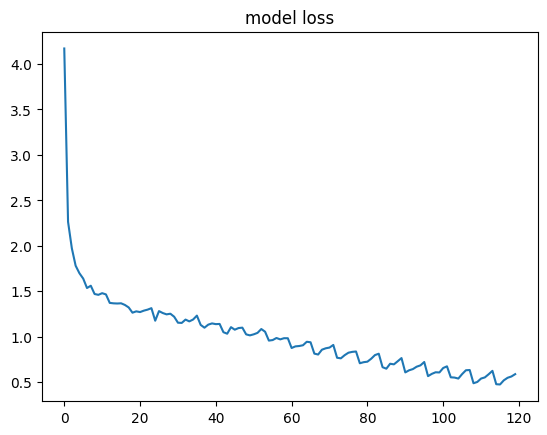

In [14]:
# Visualize the loss evolution during training
plt.plot(losses)
plt.title('model loss')
plt.show()

## Try the trained model

Let's try again to predict some characters given the input sentence 'ROMEO:'. Now the predicted characters should be much better.

In [15]:
with torch.no_grad():
    input_str = 'ROMEO:'

    state = model.init_hidden(batch_size=1)
    state = state.to(device)
    data = torch.tensor([[ShakespeareDataset.char_to_index[char] for char in input_str]]).to(device)
    output, state = model(data, state)

    _, predicted_idxs = torch.max(output[0], dim = 1)
    predicted_idxs = predicted_idxs.cpu().numpy()
    
    predicted_str = ''.join([ShakespeareDataset.index_to_char[idx] for idx in predicted_idxs])

    print(f'Input shape: {data.size()}')
    print(f'Output shape: {data.size()}')
    print(f'Input string: {input_str}')
    print(f'Output string: {predicted_str}')

Input shape: torch.Size([1, 6])
Output shape: torch.Size([1, 6])
Input string: ROMEO:
Output string: IKEO:



## Generate new text

In [16]:
def predict(dataset, model, text, next_chars=1000):
    model.eval()

    chars = [char for char in text]
    state = model.init_hidden(1)
    state = state.to(device)

    # we start by feeding all the input characters to our model
    x = torch.tensor([dataset.char_to_index[char] for char in chars])
    x = x.unsqueeze(0) # create a batch of 1
    x = x.to(device)

    for i in range(0, next_chars):
        
        y_pred, state = model(x, state)

        last_char_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_char_logits, dim=0).detach().cpu().numpy()
        char_index = np.random.choice(len(last_char_logits), p=p)
        chars.append(dataset.index_to_char[char_index])

        # the output of the model (a single character index) becomes the input at next iteration
        x = torch.tensor([[char_index]])
        x = x.to(device)

    return chars

predicted = predict(ShakespeareDataset, model,'ROMEO:')
print(''.join(predicted))

ROMEO:
So she a sault that meant this word of mine;
Cursed be pluck'd, and not remember it to me;
And these I was, I live obedient.

First Soldier:
Edward the nature.

HORTENSIO:
Marry, sir, by my fay, it was my mind.
What cursed foot wanders that thy servants do
With his harm and strawbrange foul issue. But I would
send for none.

BIANCA:
Say, Henrel, so King of Norfolk, spoke
Your knees for aught but weeping in my son.

LADY ANNE:
Where is your hands? What say you?

GRUMIO:
Always fairly belike. How we may sweet slumber
To be spoke with their infancy? to sinners' toads?
Or, how we thought the man was not his.

FROTH:
What, is't much of my occupation!

MAMILLIUS:
You'll cry out a wise and prosperous crown:
How now met, that when it bows, thou wouldst gave up myself,
How sweet a plant-strict cheer here in York
A lack of common proof so lie, and knowledge:
I have not so to end.

ISABELLA:
Too late not Did the gods.

SICINIUS:
Where's Pain?

Second Servant:
O, this it is: I would they ca

While some of the sentences are grammatically correct, most do not make sense. The model has not learned the meaning of words (we would need a much larger corpus for that, and probably a word level language model), but consider the following:

* The model is character-based. When training started, the model did not know how to spell an English word, or that words were even a unit of text. Now it does a pretty decent job on spelling.

* The structure of the output resembles a play, blocks of text generally begin with a speaker name, in all capital letters similar to the dataset.

* The model is trained on small batches of text (100 characters each), and is still able to generate a longer sequence of text with coherent structure.

# Homework

<span style="color:blue">
    
**Exercise 3:** Build two new models: one using Simple RNN cells (torch.nn.RNN) instead of GRUs(torch.nn.RNN), and the other using LSTMs (torch.nn.LSTM). Train all three models (GRU, LSTM, SimpleRNN) for 30 epochs and compare the loss curves. You can optionally try different configurations: embedding dimension, hidden layers dimensions, number of layers, etc.
    
</span>

In [17]:
class ModelSimple(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0.):
        super(ModelSimple, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # YOUR CODE HERE
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.RNN(embedding_dim, hidden_dim, n_layers, batch_first=True) 
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x, h):
        emb = self.embedding(x)
        out, h = self.gru(emb, h)
        out = self.fc(out)
        return out, h
    
    def init_hidden(self, batch_size):
        " Initialize the hidden state of the RNN to zeros"
        hidden = nn.Parameter(torch.zeros(self.n_layers, batch_size, self.hidden_dim))
        return hidden

In [28]:
class ModelLSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0.):
        super(ModelLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # YOUR CODE HERE
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True) 
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x, h):
        emb = self.embedding(x)
        out, h = self.gru(emb, (h,h)) # igual que la gru però amb un estat més
        out = self.fc(out)
        #print(h)
        return out, h
    
    def init_hidden(self, batch_size):
        " Initialize the hidden state of the RNN to zeros"
        hidden = nn.Parameter(torch.zeros(self.n_layers, batch_size, self.hidden_dim))
        return hidden

In [19]:
model = ModelSimple(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob).to(device)
lossesSimple = train(train_loader, model, batch_size, sequence_length, num_epochs)

{'epoch': 0, 'batch': 0, 'loss': 4.179138660430908}
{'epoch': 0, 'batch': 30, 'loss': 2.2222232818603516}
{'epoch': 0, 'batch': 60, 'loss': 2.008136034011841}
{'epoch': 0, 'batch': 90, 'loss': 1.870982050895691}
{'epoch': 0, 'batch': 120, 'loss': 1.8003363609313965}
{'epoch': 0, 'batch': 150, 'loss': 1.6943467855453491}
{'epoch': 1, 'batch': 0, 'loss': 1.6744260787963867}
{'epoch': 1, 'batch': 30, 'loss': 1.6008751392364502}
{'epoch': 1, 'batch': 60, 'loss': 1.6129885911941528}
{'epoch': 1, 'batch': 90, 'loss': 1.5580110549926758}
{'epoch': 1, 'batch': 120, 'loss': 1.5558195114135742}
{'epoch': 1, 'batch': 150, 'loss': 1.564408302307129}
{'epoch': 2, 'batch': 0, 'loss': 1.4611910581588745}
{'epoch': 2, 'batch': 30, 'loss': 1.4830402135849}
{'epoch': 2, 'batch': 60, 'loss': 1.4588325023651123}
{'epoch': 2, 'batch': 90, 'loss': 1.4136443138122559}
{'epoch': 2, 'batch': 120, 'loss': 1.4538755416870117}
{'epoch': 2, 'batch': 150, 'loss': 1.4592337608337402}
{'epoch': 3, 'batch': 0, 'loss':

In [20]:
model = ModelLSTM(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob).to(device)
lossesLSTM = train(train_loader, model, batch_size, sequence_length, num_epochs)

{'epoch': 0, 'batch': 0, 'loss': 4.171682357788086}
{'epoch': 0, 'batch': 30, 'loss': 2.3604538440704346}
{'epoch': 0, 'batch': 60, 'loss': 1.9841495752334595}
{'epoch': 0, 'batch': 90, 'loss': 1.8078973293304443}
{'epoch': 0, 'batch': 120, 'loss': 1.6731911897659302}
{'epoch': 0, 'batch': 150, 'loss': 1.6242306232452393}
{'epoch': 1, 'batch': 0, 'loss': 1.5243490934371948}
{'epoch': 1, 'batch': 30, 'loss': 1.499039888381958}
{'epoch': 1, 'batch': 60, 'loss': 1.4729822874069214}
{'epoch': 1, 'batch': 90, 'loss': 1.4087345600128174}
{'epoch': 1, 'batch': 120, 'loss': 1.3982969522476196}
{'epoch': 1, 'batch': 150, 'loss': 1.3820886611938477}
{'epoch': 2, 'batch': 0, 'loss': 1.3380568027496338}
{'epoch': 2, 'batch': 30, 'loss': 1.3261892795562744}
{'epoch': 2, 'batch': 60, 'loss': 1.3099175691604614}
{'epoch': 2, 'batch': 90, 'loss': 1.371262788772583}
{'epoch': 2, 'batch': 120, 'loss': 1.3238422870635986}
{'epoch': 2, 'batch': 150, 'loss': 1.3102707862854004}
{'epoch': 3, 'batch': 0, 'lo

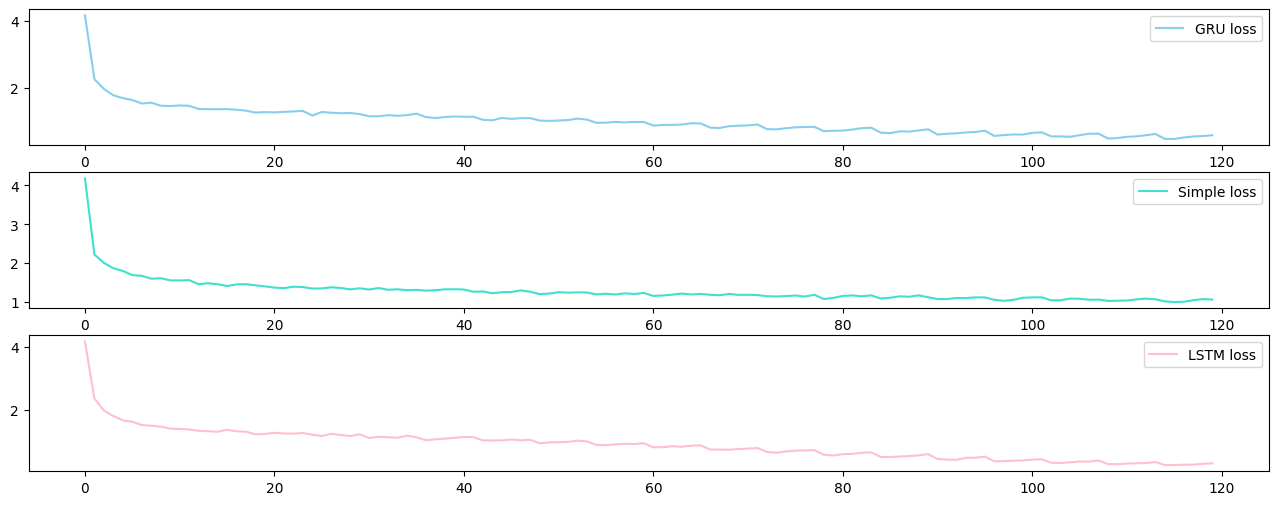

In [21]:
# Visualize the losses evolution during training
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 6))

ax1.plot(losses, label="GRU loss", color = 'skyblue')
ax1.legend()

ax2.plot(lossesSimple, label="Simple loss", color = 'turquoise')
ax2.legend()

ax3.plot(lossesLSTM, label="LSTM loss", color = 'pink')
ax3.legend()

plt.show()

<span style="color:blue">

**Exercise 4:** Train your best model on a different dataset. Use the 'inaugural' corpus of the [NLTK](https://www.nltk.org/) library. Once trained generate some text with as we did for the model trained on the Shakespeare dataset. Compare the generated texts with both models using the smae "seed" (input) text. What differences do you appreciate? Why are they different?
    
</span>

The Natural Language Toolkit, or more commonly NLTK, is a suite of datasets, libraries and models for symbolic and statistical natural language processing (NLP). The Inaugural Address Corpus contains the US presidential inaugural addresses from 1789 to 2017. The following code loads the 'inaugural' corpus:

In [38]:
import nltk
nltk.download('inaugural')

inaugural = nltk.corpus.inaugural
text = inaugural.raw()

print(f'Length of text: {len(text)} characters')

Length of text: 807276 characters


[nltk_data] Downloading package inaugural to /root/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!


In [39]:
# Modificat
class DatasetFromTextFile():
    def __init__(self, filename, sequence_length):
        self.filename = filename
        self.sequence_length = sequence_length
        
        # The whole sequence of characters in the text file (including characters like the end of line character '\n', punctuation marks, etc.)
        self.chars = self.load_chars()
        # The list of unique characters (our vocabulary)
        self.uniq_chars = self.get_uniq_chars()

        # A dictionary with indices as keys and characters as values
        self.index_to_char = {index: char for index, char in enumerate(self.uniq_chars)}
        # A dictionary with characters as keys and indices as values
        self.char_to_index = {char: index for index, char in enumerate(self.uniq_chars)}

        # The whole sequence of character indexes
        # We want to vectorize our text using one-hot vectors at character level
        # But instead of using the one-hot vector we just keep the index of the 1 value
        self.chars_indices = [self.char_to_index[w] for w in self.chars]

        # Split the sequence into chunks of `sequence_length` characters
        # `x` is the input to the model and `y` is the output of the model
        # `y` is the same seuqence as `x` but one character shifted to the right.
        self.x, self.y = self.get_data()

    def load_chars(self):
        inaugural = nltk.corpus.inaugural
        text = inaugural.raw()  
        return text

    def get_uniq_chars(self):
        char_counts = Counter(self.chars)
        uniq_chars = sorted(char_counts, key=char_counts.get, reverse=True)
        print(f'Unique characters (vocabulary size): {len(uniq_chars)}')
        return uniq_chars

    def get_data(self):
        x,y = [], []
        for index in range(0, len(self.chars_indices)-self.sequence_length, self.sequence_length):
            x.append(np.array(self.chars_indices[index:index+self.sequence_length]))
            y.append(np.array(self.chars_indices[index+1:index+self.sequence_length+1]))
        
        return  torch.from_numpy(np.array(x)), torch.from_numpy(np.array(y)).long()
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        assert ((idx >= 0) & (idx < len(self.y))), "Dataset index out of range"
        return self.x[idx], self.y[idx]

In [45]:
class ModelLSTMMod(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0.):
        super(ModelLSTMMod, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # YOUR CODE HERE
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True) 
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x, h):
        emb = self.embedding(x)

        try:
          out, h = self.gru(emb, (h,h))
        except:
          out, h = self.gru(emb, h) 
       
        out = self.fc(out)
        return out, h
    
    def init_hidden(self, batch_size):
        " Initialize the hidden state of the RNN to zeros"
        hidden = nn.Parameter(torch.zeros(self.n_layers, batch_size, self.hidden_dim))
        return hidden

Unique characters (vocabulary size): 85
We have 8072 input sequence samples of length 100 and 8072 label sequences of length 100
ModelLSTMMod(
  (embedding): Embedding(85, 300)
  (gru): LSTM(300, 1024, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1024, out_features=85, bias=True)
)
{'epoch': 0, 'batch': 0, 'loss': 4.43620491027832}
{'epoch': 0, 'batch': 30, 'loss': 2.2885162830352783}
{'epoch': 0, 'batch': 60, 'loss': 1.855322003364563}
{'epoch': 0, 'batch': 90, 'loss': 1.638624906539917}
{'epoch': 0, 'batch': 120, 'loss': 1.4940623044967651}
{'epoch': 1, 'batch': 0, 'loss': 1.4481325149536133}
{'epoch': 1, 'batch': 30, 'loss': 1.380922794342041}
{'epoch': 1, 'batch': 60, 'loss': 1.321122407913208}
{'epoch': 1, 'batch': 90, 'loss': 1.3007742166519165}
{'epoch': 1, 'batch': 120, 'loss': 1.2634682655334473}
{'epoch': 2, 'batch': 0, 'loss': 1.2134867906570435}
{'epoch': 2, 'batch': 30, 'loss': 1.2103685140609741}
{'epoch': 2, 'batch': 60, 'loss': 1.2006200551986694}
{'epoch'

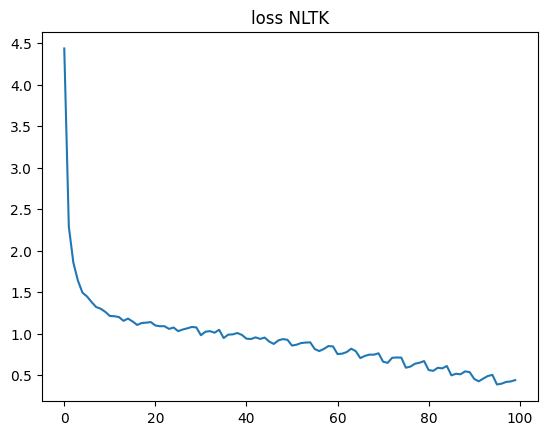

In [46]:
# Create the Dataset
sequence_length = 100
nltkDataset = DatasetFromTextFile(text, sequence_length)

print(f'We have {nltkDataset.x.shape[0]} input sequence samples of length {nltkDataset.x.shape[1]} \
and {nltkDataset.y.shape[0]} label sequences of length {nltkDataset.y.shape[1]}')

# Create the Torch DataLoader
batch_size = 64
train_loader = DataLoader(nltkDataset, shuffle=True, batch_size=batch_size, drop_last=True)

# Define model
input_dim = len(nltkDataset.uniq_chars)
output_dim = len(nltkDataset.uniq_chars)

model4 = ModelLSTMMod(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob).to(device)

print(model4)

# Train model
num_epochs = 20
losses4 = train(train_loader, model4, batch_size, sequence_length, num_epochs)

plt.plot(losses4)
plt.title('loss NLTK')
plt.show()

In [47]:
def predictNew(dataset, model, text, next_chars=1000):
    model.eval()

    chars = [char for char in text]
    state = model.init_hidden(1)
    state = state.to(device)

    # we start by feeding all the input characters to our model
    x = torch.tensor([dataset.char_to_index[char] for char in chars])
    x = x.unsqueeze(0) # create a batch of 1
    x = x.to(device)

    for i in range(0, next_chars):
        
        y_pred, state = model(x, state)

        last_char_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_char_logits, dim=0).detach().cpu().numpy()
        char_index = np.random.choice(len(last_char_logits), p=p)
        chars.append(dataset.index_to_char[char_index])

        # the output of the model (a single character index) becomes the input at next iteration
        x = torch.tensor([[char_index]])
        x = x.to(device)

    return chars

predicted = predictNew(nltkDataset, model4,'Among')
print(''.join(predicted))

Among them, like the people, who covered our hearts and hearthstops and of revolution has confidence because the favor encourages that which is granted to venture with an impeneating detriment to acquiesce. We ought to be, the key to those from master as may give more friend, can though for the islands, and the promotes of mankind, the sovereign was ample funcies of various chance, that the mere so much in the presence of justice has arisen in a spirit of sectional pride, and that the mistaken eradicate conference in the hands of the United States, Jefiles to make him desirable for the maintenance of fear and distrust, and that I should render the immediate work of as about to enter on the discipline and inspiring missiles which we could need that then could start from the place that make hope of the whole world and in other improvements of necessarily progress.

I have come to a tariff for profit -- have greater every period of life. I welcome it, as a benefith and conspicuous, beneat